In [0]:
!wget https://www.dropbox.com/s/tridhlj6xjqom90/anpr_ocr-1790.zip?dl=0
!wget https://www.dropbox.com/s/gcs7wxsc847xh2h/numbers.JPG?dl=0
!mv numbers.JPG?dl=0 numbers.JPG
!wget https://www.dropbox.com/s/52mptr26gpl8foo/bill-out.PNG?dl=0
!mv bill-out.PNG?dl=0 bill-out.PNG
!unzip anpr_ocr-1790.zip?dl=0

In [0]:
import cv2
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import string

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
dataset_path = "train/anpr_ocr/train/img/"
x0 = []
y0 = []
for i in os.listdir(dataset_path):
    image = cv2.imread(dataset_path + i)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (128, 32))
    # plt.imshow(image)
    image = image.astype(np.float32)
    x0.append(image)
    y0.append(i.split('.')[0])

In [0]:
# Label format 
# ['_', '3',  'O',  '1',  'E',  'P',  '7',  '9',  '0',  'X',  '2',  'T',  '6',  'Y',  'M',  'A',  'C',  'B',  '5',  '8',  'H',  '4',  'K']
# import itertools
# charList = ["_"]
# charList.extend(list(set(itertools.chain(*y0))))
charList = ['_'] + list(map(str, range(0, 10))) + list(string.ascii_uppercase)
charList, len(charList)

(['_',
  '0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  'A',
  'B',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'J',
  'K',
  'L',
  'M',
  'N',
  'O',
  'P',
  'Q',
  'R',
  'S',
  'T',
  'U',
  'V',
  'W',
  'X',
  'Y',
  'Z'],
 37)

In [0]:
max_len = max([len(i) for i in y0])
# max_len = 32
targets = []
for i in y0:
    seq = list(map(lambda x0: charList.index(x0), i))
    while len(seq) < max_len:
        seq.append(0)
    targets.append(seq)

In [0]:
np.asarray(x0).shape

(10281, 32, 128)

In [0]:
# x0 = np.asarray(x0).reshape(10281, 1, 64, 128)
x0 = np.asarray(x0).reshape(10281, 1, 32, 128)
# x0 = np.asarray(x0)
targets = np.asarray(targets)
x0 = x0/255
x0.shape, targets.shape

((10281, 1, 32, 128), (10281, 8))

In [0]:
targets[0]

array([34,  3,  1,  6, 15, 21,  1, 10])

In [0]:
x2 = torch.from_numpy(x0)
y2 = torch.from_numpy(targets)
input_lengths = torch.full(size=(10281,), fill_value=32, dtype=torch.long)
# input_lengths = torch.full(size=(10281,), fill_value=80, dtype=torch.long)
target_lengths = torch.full(size=(10281,), fill_value=8, dtype=torch.long)
input_lengths, target_lengths

(tensor([37, 37, 37,  ..., 37, 37, 37]), tensor([8, 8, 8,  ..., 8, 8, 8]))

In [0]:
y2[0:2]

tensor([[34,  3,  1,  6, 15, 21,  1, 10],
        [12,  1,  3,  8, 34, 35,  3,  4]])

# Model creation

In [0]:
class OCR(nn.Module):
    def __init__(self):
        super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=(1, 1)) # (N, Channels, Height, Width)
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=(1, 1)) # (N, Channels, Height, Width)
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=(1, 1)) # (N, Channels, Height, Width)
        self.conv3 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=(3, 3), padding=(1, 1)) # (N, Channels, Height, Width)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=(1, 1)) # (N, Channels, Height, Width)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=(1, 1)) # (N, Channels, Height, Width)
        self.gru1 = nn.GRU(input_size=256, hidden_size=256, num_layers=1, batch_first=True, bidirectional=True)
        self.gru2 = nn.GRU(input_size=256, hidden_size=256, num_layers=1, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(512, len(charList))
        self.softmax = torch.nn.Softmax(dim=-1)
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=(1, 1)) # (N, Channels, Height, Width)
#         self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=(1, 1)) # (N, Channels, Height, Width)
#         self.dense1 = nn.Linear(16*16, 32)
#         self.gru1 = nn.GRU(input_size=32, hidden_size=512, num_layers=1, batch_first=True, bidirectional=True)
#         self.gru2 = nn.GRU(input_size=512, hidden_size=512, num_layers=1, batch_first=True, bidirectional=True)
#         self.dense2 = nn.Linear(1024, len(charList))
#         self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
#         conv1 = F.relu(self.conv1(x))
# #         print("Conv1 shape:", conv1.shape)
#         pool1 = F.max_pool2d(conv1, 2, 2)
# #         print("Pool1 shape:", pool1.shape)
#         conv2 = F.relu(self.conv2(pool1))
# #         print("Conv2 Shape:", conv2.shape)
#         pool2 = F.max_pool2d(conv2, 2, 2)
# #         print("Pool2 shape", pool2.shape)
#         reshaped = pool2.view(-1, 32, 16*16)
# #         print("Reshape shape", reshaped.shape)
# #         reshaped = reshaped.permute(0, 2, 1)
# #         print("Permuted shape", reshaped.shape)
#         dense1 = F.relu(self.dense1(reshaped))
#         gru1_output, (gru1_hidden, gru1_cell) = self.gru1(dense1)
# #         print("Gru1 output shape:", gru1_output.shape)
#         gru1_shape = gru1_output.shape
#         gru1_reshaped = gru1_output.view(gru1_shape[0], gru1_shape[1], 2, 512)
# #         print("Gru1 shape:", gru1_reshaped.shape)
#         gru1_fwd = gru1_reshaped[:, :, 0, :]
# #         print("GRU1 fwd shape:", gru1_fwd.shape)
#         gru1_bwd = gru1_reshaped[:, :, 1, :]
# #         print("GRU1 bwd shape:", gru1_bwd.shape)
#         gru1 = gru1_fwd + gru1_bwd
# #         print("GRU1 shape:", gru1.shape)
#         gru2_output, (gru2_hidden, gru2_cell) = self.gru2(gru1)
# #         print("GRU2 output shape:", gru2_output.shape)
#         dense2 = F.relu(self.dense2(gru2_output))

# #         print("Dense shape: ", dense2.shape)
# #         output = self.softmax(dense2)
#         output = dense2

# #         print("Output shape: ", dense2.shape)
#         output_permuted = output.view(output.shape[1], output.shape[0], output.shape[2])
# #         print("Permuted shape:", output_permuted.shape)
#         return output_permuted
        
        
        
        # print("Input shape:", x.shape)
#         conv1 = F.relu(self.conv1(x))
#         print("Conv1 shape:", conv1.shape)
#         pool1 = F.max_pool2d(conv1, 2, 2)
#         print("Pool1 shape:", pool1.shape)
#         conv2 = F.relu(self.conv2(pool1))
#         print("Conv2 shape:", conv2.shape)
#         pool2 = F.max_pool2d(conv2, 2, 2)
#         print("Pool2 shape:", pool2.shape)
#         conv3 = F.relu(self.conv3(pool2))
        conv3 = F.relu(self.conv3(x))
        # print("Conv3 shape:", conv3.shape)
        pool3 = F.max_pool2d(conv3, 2, 2)
        # print("Pool3 shape:", pool3.shape)
        conv4 = F.relu(self.conv4(pool3))
        # print("Conv4 shape:", conv4.shape)
        pool4 = F.max_pool2d(conv4, 2, 4)
        # print("Pool4 shape:", pool4.shape)
        fc = pool4.view(-1, 2*16, 256)
        # print("FC shape:", fc.shape)
        gru1_output, (gru1_hidden, gru1_cell) = self.gru1(fc)
        # print("GRU1 output:", gru1_output.shape)
        gru_reshaped = gru1_output.view(-1, 32, 2, 256)
        # print("GRU1 reshaped shape:", gru_reshaped.shape)
        gru_fwd = gru_reshaped[:, :, 0, :]
        # print("GRU FWD shape:", gru_fwd.shape)
        gru_bwd = gru_reshaped[:, :, 1, :]
        # print("GRU BWD shape:", gru_bwd.shape)
        gru1 = gru_fwd + gru_bwd
        # print("Gru1 shape:", gru1.shape)
        gru2_output, (gru2_hidden, gru2_cell) = self.gru2(gru1)
        # print("GRU2 output shape:", gru2_output.shape)
        dense = self.linear(gru2_output)
        # print("Dense shape:", dense.shape)
        output = F.relu(dense)
#         output = self.softmax(dense)
        # print("Ouptut Shape:", output.shape)
        return output.permute(1, 0, 2)


In [0]:
model = OCR().to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)
criterion = nn.CTCLoss(blank=0)

In [0]:
model

OCR(
  (conv3): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gru1): GRU(256, 256, batch_first=True, bidirectional=True)
  (gru2): GRU(256, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=37, bias=True)
  (softmax): Softmax(dim=-1)
)

# Create Traning dataset batch by batch

In [0]:
class training_data():
    def __init__(self, batch_size):
        self.current_index = 0
        self.len = len(x2)
        self.batch_size = batch_size

    def next_samples(self):
        
        x = x2[self.current_index:self.current_index+self.batch_size]
        y = y2[self.current_index:self.current_index+self.batch_size]
        x_lengths = input_lengths[self.current_index:self.current_index+self.batch_size]
        y_lengths = target_lengths[self.current_index:self.current_index+self.batch_size]
        # x_lengths = torch.full(size=(self.batch_size,), fill_value=len(charList), dtype=torch.long)
        # y_lengths = torch.full(size=(self.batch_size,), fill_value=8, dtype=torch.long)
        
        
        self.current_index = self.current_index + self.batch_size
        
        if self.current_index >= self.len:
            self.current_index = 0
        
        return x, y, x_lengths, y_lengths
            
            
    def next_batch(self):
        # print("Data between {} and {}".format(self.current_index, self.current_index+self.batch_size))
        x, y, x_lengths, y_lengths = self.next_samples()
        return (x, y, x_lengths, y_lengths)

In [0]:
input_lengths[:100]

tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37])

In [0]:
len(x2) // 2500

4

# Train the model

In [0]:
epochs = 1000
loss_history = []
acc_history = []
batch_size = 128
training_dataset = training_data(batch_size)

# x, y, x_lens, y_lens = training_dataset.next_batch()
# x, y, x_lens, y_lens = x2[:100], y2[:100], input_lengths[:100], target_lengths[:100]

# x = x.to(device)
# y = y.to(device)

# x_lens = x_lens.to(device)
# y_lens = y_lens.to(device)

for i in range(epochs):
    print("***************** Epochs {} *****************".format(i))
    for batch in  range(len(x2)//batch_size):
        # print("Batch:", batch)
        x, y, x_lens, y_lens = training_dataset.next_batch()
        x = x.to(device)
        y = y.to(device)

        x_lens = x_lens.to(device)
        y_lens = y_lens.to(device)
        print(x)
        print(y)
        print(x_lens)
        print(y_lens)
    #     running_loss = 0.0
    #     for j in range(len(x2)//batch_size):
    #         print(j)
    #         print(x_lens)
        
        
        pred = model.forward(x)
        
        # print(pred.shape)
        # print(y.shape)
        pred = pred.log_softmax(2)
        print(pred.shape)
    #         print(pred.shape)
    #         print(y.shape)
    #         print(x_lens.shape)
    #         print(y_lens.shape)
        loss = criterion(pred[:, :, :], y, x_lens, y_lens)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        if i % 100 == 0:
            print(loss.item())
    #         print(loss.item())
    #     running_loss += loss.item()
        
    #     epoch_loss = running_loss * batch_size / len(x)
    #     loss_history.append(epoch_loss)
    #     print("Loss: ", epoch_loss)

***************** Epochs 0 *****************
tensor([[[[0.7765, 0.4627, 0.3647,  ..., 0.3647, 0.4627, 0.7765],
          [0.2588, 0.1686, 0.1333,  ..., 0.1333, 0.1686, 0.2588],
          [0.0980, 0.1765, 0.5294,  ..., 0.5294, 0.1765, 0.0980],
          ...,
          [0.1569, 0.1294, 0.2549,  ..., 0.2549, 0.1294, 0.1569],
          [0.5098, 0.1373, 0.1059,  ..., 0.1059, 0.1373, 0.5098],
          [0.7333, 0.6863, 0.6667,  ..., 0.6667, 0.6863, 0.7333]]],


        [[[0.7765, 0.4627, 0.3647,  ..., 0.3647, 0.4627, 0.7765],
          [0.2588, 0.1686, 0.1333,  ..., 0.1333, 0.1686, 0.2588],
          [0.0980, 0.1765, 0.5294,  ..., 0.5294, 0.1765, 0.0980],
          ...,
          [0.1569, 0.1294, 0.2549,  ..., 0.2549, 0.1294, 0.1569],
          [0.5098, 0.1373, 0.1059,  ..., 0.1059, 0.1373, 0.5098],
          [0.7333, 0.6863, 0.6667,  ..., 0.6667, 0.6863, 0.7333]]],


        [[[0.7765, 0.4627, 0.3647,  ..., 0.3647, 0.4627, 0.7765],
          [0.2588, 0.1686, 0.1333,  ..., 0.1333, 0.1686, 0.

RuntimeError: ignored

# Predict Image

In [0]:
def final_output(predicted_output):
    predicted_output = [charList[i[0]] for i in predicted_output]
    print(predicted_output)
    output = ['_']
    for i in predicted_output:
        if i == output[-1]:
            continue
        output.append(i)

    output = [i for i in output if i != '_']
    return ''.join(output[:8])

Input Image: 


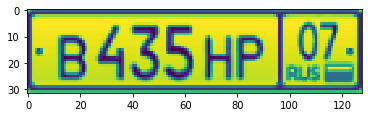

In [0]:
image_index = -4
plt.imshow(x[image_index].view(32, 128).to(torch.device('cpu')))
plt.plot()
print("Input Image: ")

In [0]:
print("Number in the number plate image:", final_output(model.forward(x[image_index].view(1, 1, 32, 128).to(device)).argmax(-1).tolist()))

['B', '_', '_', '4', '_', '3', '_', '5', '_', '_', '_', '_', '_', '_', '_', '_', 'H', '_', 'P', '_', '_', '0', '7', '7', '7', '7', '7', '7', '7', '7', '7', '_']
Number in the number plate image: B435HP07


# Mounting Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/weights

numberplate_ocr_torch_1000.pt


# Save Model

In [0]:
torch.save(model, '/content/gdrive/My Drive/Colab Notebooks/weights/numberplate_ocr_torch_{}.pt'.format(epochs))

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type OCR. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages

In [0]:
model2 = torch.load('/content/gdrive/My Drive/Colab Notebooks/weights/numberplate_ocr_torch_1000.pt').to(device)

# End loading page

In [0]:
assert False

AssertionError: ignored

# For CTC loss calculation

In [0]:
# pred.shape, y.shape, x_lengths.shape, y_lengths.shape
from torch.autograd import Variable

In [0]:
T = 50      # Input sequence length
C = 20      # Number of classes (including blank)
N = 16      # Batch size
S = 30      # Target sequence length of longest target in batch
S_min = 10  # Minimum target length, for demonstration purposes

# Initialize random batch of input vectors, for *size = (T,N,C)
# input = torch.randn(T, N, C).log_softmax(2).detach().requires_grad_()
input = Variable(torch.randn(T, N, C).log_softmax(2), requires_grad=True)

# Initialize random batch of targets (0 = blank, 1:C = classes)
target = torch.randint(low=1, high=C, size=(N, S), dtype=torch.long)

input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
target_lengths = torch.randint(low=S_min, high=S, size=(N,), dtype=torch.long)
ctc_loss = nn.CTCLoss()
loss = ctc_loss(input, target, input_lengths, target_lengths)
loss.backward()

In [0]:
input.shape, target.shape, input_lengths.shape, target_lengths.shape

In [0]:
input[:, 0, :]

In [0]:
loss.item()

In [0]:
plt.imshow((x[0] * 255).view(64, 128).numpy())

In [0]:
[charList[i] for i in y[0]]

In [0]:
y_lengths

In [0]:
y